In [546]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_wine
from sklearn.metrics import f1_score, log_loss, accuracy_score
from random import sample 
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

### Data Preprocessing

In [494]:
from sklearn.datasets import load_wine
from sklearn import preprocessing
import pandas as pd

raw_data = load_wine()
data = pd.DataFrame(data = raw_data['data'], columns = raw_data['feature_names'])
data['class'] = raw_data['target']
data = data.loc[data['class'] != 2,:]
data['class'][data['class'] == 1] = -1
data['class'][data['class'] == 0] = 1
y = data[['class']]
data.insert(loc=0, column='b', value=1)
data1 = data.copy()
data2 = data.copy()

min_max_scaler = preprocessing.MinMaxScaler()
data1.iloc[:,1:] = min_max_scaler.fit_transform(data1.iloc[:,1:].values)

cols = list(data2.columns)
for i in cols[1:-1]:
    scaler_train = StandardScaler()
    sf_train = scaler_train.fit(data2[[i]])
    data2[i] = sf_train.transform(data2[[i]])

train1 = data1.iloc[:,:-1]
train2 = data2.iloc[:,:-1]

/Users/chenxuanyu212/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


### Logistic regression with sklearn

In [502]:
clf = LogisticRegression(random_state=0, C=50).fit(train1,y)
y_proba = clf.predict_proba(train1)
loss_star1 = log_loss(y, y_proba)

clf = LogisticRegression(random_state=0, C=50).fit(train2,y)
y_proba = clf.predict_proba(train2)
loss_star2 = log_loss(y, y_proba)
print(loss_star1,loss_star2)

0.02101796143246044 0.0022908920038074683


### Coordinate Descent

In [503]:
def loss_logistic(w,df_x,y):
    '''
        w: vector of w_hat([b,w1,w2,...,wd])
        df_x: dataframe of X_hat(insert one col of 1 at the index 0 of X_train)
        y: vector of labels
        return: the value of loss function of logistic regression
    '''
    result = 0
    for i in range(0,len(df_x)):
        x = df_x.loc[i,:].values
        temp = np.log(1 + np.exp(-y[i] * x.dot(w)))
        result += temp
    return result

def Derivative_loss_logistic_wrt_wk(w,df_x,y,index):
    '''
        w: vector of w_hat([b,w1,w2,...,wd])
        df_x: dataframe of X_hat(insert one col of 1 at the index 0 of X_train)
        y: vector of labels
        index: the index of chosen coordinate
        return: the value of the first derivative of loss function of logistic regression
    '''
    result = 0
    for i in range(0,len(df_x)):
        x = df_x.loc[i,:].values
        temp = (-y[i] * x[index] * np.exp(-y[i] * x.dot(w)))/(1 + np.exp(-y[i] * x.dot(w)))
        result += temp
    return result
        
        

#### if choose index randomly

In [539]:
def coordinate_descent(x_hat,max_iter,alpha,threshold):
    # hyper-parameters
    max_iter = max_iter
    alpha = alpha # step size
    threshold = threshold

    # initialize
    t = 0
    w = np.random.uniform(-1,1,X_hat.shape[1])
    list_optimal_value = []
    #w = np.array([0]*14)
    optimize = False
    loss = loss_logistic(w,X_hat,y_hat)

    while (optimize == False) & (t < max_iter):
        list_index = list(range(0,X_hat.shape[1]))
        chosen_index = []
        # choose index randomly
        # To Do: choose index which is argmax f'(wt)
        index = sample(list(range(0,X_hat.shape[1])),1)[0]
        chosen_index.append(index)
        # update w at the index coordinate
        temp_w = w.copy()
        temp_w[index] = w[index] - alpha * Derivative_loss_logistic_wrt_wk(w,X_hat,y_hat,index)
        # calculate the newest loss
        temp_loss = loss_logistic(temp_w,X_hat,y_hat)

        # check weather termination test satisfies
        while (loss - temp_loss) <= threshold: # which means the we need to change to another coordinate
            #print('jinlaile')
            left = [x for x in list_index if x not in chosen_index ]
            index = sample(left,1)[0]
            chosen_index.append(index)
            # update w at the index coordinate
            temp_w = w.copy()
            temp_w[index] = w[index] - alpha * Derivative_loss_logistic_wrt_wk(w,X_hat,y_hat,index)
            # calculate the newest loss
            temp_loss = loss_logistic(temp_w,X_hat,y_hat)

            if len(chosen_index) == len(w):
                optimize = True
                break


        loss = temp_loss
        list_optimal_value.append(loss)
        w = temp_w.copy()
        t += 1

    print(t)  
    print(loss)
    return loss,list_optimal_value

In [542]:
optimal_loss, list_loss = coordinate_descent(x_hat = train1,max_iter = 9000, alpha = 0.1, threshold = 1e-6)

9000
0.03864519720399256


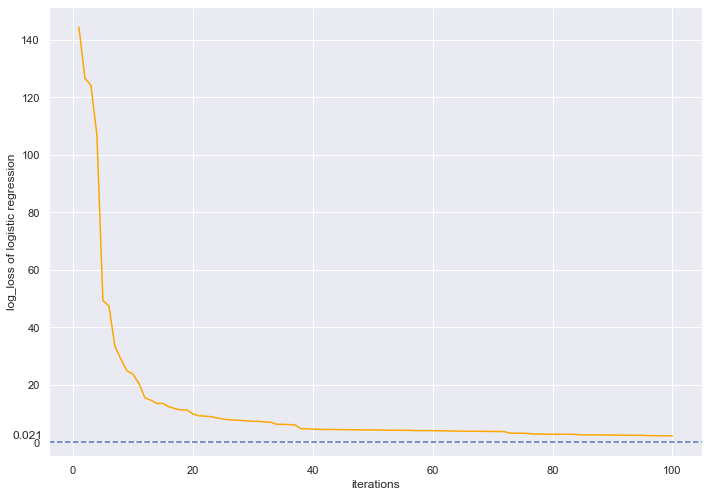

In [582]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
fig = sns.lineplot(x=list(range(1,101)),y=list_loss[:100],color='orange')
fig.axhline(0.02101796143246044, ls='--')
fig.text(-10,1.3, "0.021")
fig.set(xlabel='iterations',ylabel='log_loss of logistic regression')
plt.show()

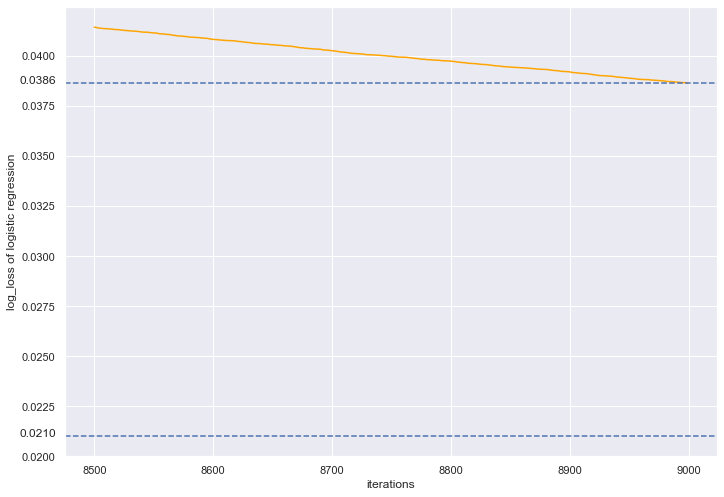

In [594]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
fig = sns.lineplot(x=list(range(8500,9000)),y=list_loss[8500:],color='orange')
fig.axhline(0.02101796143246044, ls='--')
fig.axhline(0.03864519720399256, ls='--')
fig.text(8437,0.0386, "0.0386")
fig.text(8437,0.021, "0.0210")
fig.set(xlabel='iterations',ylabel='log_loss of logistic regression')
plt.show()

### choose index choose index which is argmax f'(wt)

In [530]:
def coordinate_descent2(x_hat,max_iter,alpha,threshold):
    # hyper-parameters
    max_iter = max_iter
    alpha = alpha # step size
    threshold = threshold

    # initialize
    t = 0
    w = np.random.uniform(-1,1,X_hat.shape[1])
    optimize = False
    loss = loss_logistic(w,X_hat,y_hat)

    while (optimize == False) & (t < max_iter):
        list_index = list(range(0,X_hat.shape[1]))
        chosen_index = []
        # To Do: choose index which is argmax f'(wt)
        derivative= []
        for i in list_index:
            derivative.append(abs(Derivative_loss_logistic_wrt_wk(w,X_hat,y_hat,i)))
        index = derivative.index(max(derivative))
        
        chosen_index.append(index)
        # update w at the index coordinate
        temp_w = w.copy()
        temp_w[index] = w[index] - alpha * Derivative_loss_logistic_wrt_wk(w,X_hat,y_hat,index)
        # calculate the newest loss
        temp_loss = loss_logistic(temp_w,X_hat,y_hat)

        # check weather termination test satisfies
        while (loss - temp_loss) <= threshold: # which means the we need to change to another coordinate
            #print('jinlaile')
            left = [x for x in list_index if x not in chosen_index]
            derivative= []
            for i in left:
                derivative.append(abs(Derivative_loss_logistic_wrt_wk(w,X_hat,y_hat,i)))
            index = derivative.index(max(derivative))
            chosen_index.append(index)
            # update w at the index coordinate
            temp_w = w.copy()
            temp_w[index] = w[index] - alpha * Derivative_loss_logistic_wrt_wk(w,X_hat,y_hat,index)
            # calculate the newest loss
            temp_loss = loss_logistic(temp_w,X_hat,y_hat)

            if len(chosen_index) == len(w):
                optimize = True
                break


        loss = temp_loss
        w = temp_w.copy()
        t += 1

    print(t)  
    print(loss)
    return loss

In [531]:
coordinate_descent2(x_hat = train1,max_iter = 1500, alpha = 0.1, threshold = 0.0001)

1381
0.15494772265430196


0.15494772265430196

In [407]:
t

404